In [2]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import colorcet as cc
import cartopy
import cartopy.crs as ccrs
import csv
import copy as cp
import random as rand
from scipy.stats import pearsonr, linregress
from scipy.signal import detrend
from scipy.io import loadmat
from matplotlib import cm, colors
from numba import njit, vectorize

In [3]:
#The interval of time we're looking at (1980 to 2019)
startyear = 1980
endyear = 2010
timeseries = np.arange(startyear, endyear + 1, 1) #yearly
timeseries_cont = np.arange(startyear, endyear + 1, 1/12) #monthly

#dictionary of months
monthsnum = np.arange(1,13,1)
monthsind = np.arange(0,12,1)
monthsstr = ['01','02','03','04','05','06','07','08','09','10','11','12']
monthsnam = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
months = {1:'January',2:'February',3:'March',
          4:'April',5:'May',6:'June',7:'July',8:'August',
          9:'September',10:'October',11:'November',12:'December'}
names = ['NSIDC','Had2CIS','CANCM4','GEM_NEMO','COMBINED']
ensembles = np.arange(0,10,1)

#colours for graphing
col = ['navy','mediumblue','mediumslateblue','violet',
       'maroon','red','orange','gold','lime',
       'forestgreen','purple','darkturquoise']

#regions
PanAntarctic = [0,360]
Weddell = [300,20]
Indian = [20,90]
WestPacific = [90,160]
Ross = [160,230]
Amundsen = [230,300]

In [4]:
#function to calculate sea ice extent from sea ice fraction/concentration

@njit
def calculate_SIE (SIC_array, latdat, londat, region):
    '''
    SIC_array: 2D array of SIC values in the form of [lat][lon]
    lat: 1D array of all latitudes
    lon: 1D array of all longitudes
    '''
    
    #Will keep track of sea ice extent
    SIE_counter = 0

    #iterate over all latitudes and longitudes
    for i in range(len(latdat)): 
        for j in range(len(londat)):
            
            #only consider SOUTHERN hemisphere
            if latdat[i] < 0:
                
                #only consider a certain region
                if region[0] > region[1]:
                    if londat[j] >= region[0] or londat[j] <= region[1]:

                        SIC = SIC_array[i][j]

                        if SIC >= 0.15: 
                            SIE_counter += (111.12**2) * np.abs(np.cos(latdat[i]*(np.pi/180)))
                            #km^2 area of each 1x1deg grid cell near south pole
                else:
                    if londat[j] >= region[0] and londat[j] <= region[1]:

                        SIC = SIC_array[i][j]

                        if SIC >= 0.15: 
                            SIE_counter += (111.12**2) * np.abs(np.cos(latdat[i]*(np.pi/180)))
                            #km^2 area of each 1x1deg grid cell near south pole
                            
    return SIE_counter/1e6



#function to write data to .txt file

def writedat(yearlydata, filename, loc = "Region_PanAntarcticSIE"):
    '''
    yearlydata: (dictionary) the data to be written to file, in the form of a dictionary
    filename: (string) the name of the file, excluding the .txt
    '''

    #First, create file
    #x is to create file
    #w is to rewrite file. If file doesn't exist, create file.
    #a is to append to file. If file doesn't exist, create file.
    #r is to read file

    f = open(loc + "/" + str(filename) + ".txt", "w")

    #go year by year
    for year in yearlydata.keys():

        f.write(str(year) + " ")

        #SIE month by month for the above year
        for val in yearlydata[year]:

            f.write(str(val) + " ")

        f.write("\n")

    f.close()
    
    
    
#function to retrieve data from .txt file

def retrievedat (filename, loc = "Region_PanAntarcticSIE"):
    '''
    retrieve data from a .txt file in a specific format
    '''
    
    #dictionary full of data to be returned
    datadict = {}
    
    f = open(loc + "/" + str(filename) + ".txt", "r")
    
    #go line by line
    for line in f:
        
        #split line into an array
        line.replace('\n', '')
        linearray = line.split()
        
        year = np.int64(linearray[0])
        dat = linearray[1:]
        
        #convert nones to None and values to floats
        for i,d in enumerate(dat):
            if d == 'None':
                dat[i] = np.nan
            else:
                dat[i] = np.float64(d)
        
        datadict[year] = dat
    
    f.close()
    
    return datadict



#function to calculate average of array w/ None types

def average (array):
    
    net = 0
    count = 0
    
    for dat in array:
        if dat is not None and np.isnan(dat) == False:
            net += dat
            count += 1
            
    return net/count


#function to calculate average between CANCM4 and GEM_NEMO

def model_average (model1, model2, N=2):
    
    dictaveraged = {}
    
    for year in timeseries:
        
        dictaveraged[year]= [np.nan]*12
        
        for leadtime in monthsind:
            
            net = model1[year][leadtime] + model2[year][leadtime]
            ave = net/N #average
            
            dictaveraged[year][leadtime] = ave
    
    return dictaveraged


#function to retrieve all data pertaining to a specific month of the year

def DataForMonth (dataset, month, initmonth = 1):
    
    #Determine what type the input is in (e.g. array or dictionary)
    if type(dataset) == dict:
        dataset1D = Dict1D(dataset)
    else:
        dataset1D = dataset
            
    #Now pick out all the data corresponding to the specified month
    #e.g. if month = 1 and initmonth = 1, then it should pick out index 0, index 12, index 24, etc...
    
    index = (month - 1) - (initmonth - 1)
    datasetmonth = []

    if month < initmonth:
        index += 12
    while index < len(dataset1D):
        datasetmonth.append(dataset1D[index])
        index += 12 #jump forward 12 months
            
    return datasetmonth


#Put a dictionary of data into a 1D array

def Dict1D (dataset):
    
    #put all the data into a 1D array
    
    dataset1D = []
    for year in dataset.keys():
        for im in monthsind:
            dataset1D.append(dataset[year][im])
    
    return dataset1D


# CanCM4

In [69]:
filename = "CanCM4free\\sic_OImon_CanCM4_historical_rcp45_r1i1p1_196101-203512_1x1.nc"
file = nc.Dataset(filename, 'r')
SICdata = np.array(file.variables['sic'][:])/100
latitudes = np.array(file.variables['lat'][:])
longitudes = np.array(file.variables['lon'][:])
file.close()

<ipython-input-69-66dd71718029>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  SICdata = np.array(file.variables['sic'][:])/100
<ipython-input-69-66dd71718029>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  latitudes = np.array(file.variables['lat'][:])
<ipython-input-69-66dd71718029>:5: DeprecationWarning: `np.bool` is a deprecated alias for t

In [70]:
CanCM4dat_free = []

for dat_yrmt in SICdata: #get data for a specific year and month
    
    #calculate SIE
    SIE = calculate_SIE(dat_yrmt, latitudes, longitudes, PanAntarctic)
    CanCM4dat_free.append(SIE)

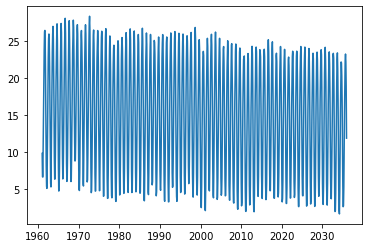

In [71]:
plt.plot(np.arange(1961, 2036, 1/12),CanCM4dat_free)

# CanESM5

In [9]:
filename = "CanESMfree\\siconc_monthly_CanESM5_185001-201412_1x1.nc"
file = nc.Dataset(filename, 'r')
SICdata = np.array(file.variables['siconc'][:])/100
latitudes = np.array(file.variables['lat'][:])
longitudes = np.array(file.variables['lon'][:])
file.close()

#get rid of stand-in values of siconc for landmasses
SICdata[SICdata > 100] = 0

<ipython-input-9-816a9d5f6ba5>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  SICdata = np.array(file.variables['siconc'][:])/100
<ipython-input-9-816a9d5f6ba5>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  latitudes = np.array(file.variables['lat'][:])
<ipython-input-9-816a9d5f6ba5>:5: DeprecationWarning: `np.bool` is a deprecated alias for t

In [11]:
CanESM5dat_free = []

for dat_yrmt in SICdata: #get data for a specific year and month
    
    #calculate SIE
    SIE = calculate_SIE(dat_yrmt, latitudes, longitudes, PanAntarctic)
    CanESM5dat_free.append(SIE)

C:\Users\Robert payne\anaconda3\lib\site-packages\numba\core\ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'region' of function 'calculate_SIE'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-4-7aa40ad9c9fe>", line 4:
@njit
def calculate_SIE (SIC_array, latdat, londat, region):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


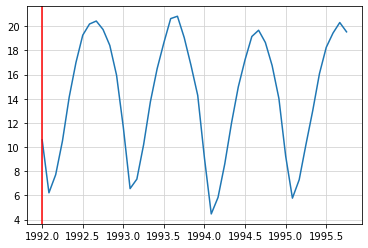

In [51]:
a,b=[1704,1750]

#ind0 = 1850
#ind1560 = 1980 
#ind1704 = 1992

#b = 1850
#m = 12

plt.plot(np.arange(1850, 2015, 1/12)[a:b],CanESM5dat_free[a:b])
plt.axvline(1992,color='red')
plt.grid(color='lightgrey')

In [62]:
def get_yr_ind (yr):
    return 12*(yr-1850)

In [67]:
get_yr_ind(2010)

1920